In [1]:
from pathlib import Path
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn import linear_model

import sys
sys.path.insert(0, '..')

from scripts.raster_processing.read import read
from scripts.raster_processing.clip import clip
from scripts.raster_processing.raster_to_dataframe import raster_to_dataframe

In [2]:
YEARS = [2000, 2005, 2010, 2015, 2020]
PREDICTION_YEARS = [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]
AGE_GROUPS = [0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

In [3]:
pop_group = "f_20"
raster_names = [f"{pop_group}_{year}.tif" for year in YEARS]
raster_directory = Path("../data/output/population_grids_togo/")
print(raster_names)

['f_20_2000.tif', 'f_20_2005.tif', 'f_20_2010.tif', 'f_20_2015.tif', 'f_20_2020.tif']


In [4]:
togo_borders = gpd.read_file("../data/input/borders/togo/salb_borders.zip")
togo_borders.head()

,db_c4f0x_h,iso3cd,cty_nm,adm1nm,adm2nm,adm1cd,adm2cd,globalid,st_area_sh,st_length_,geometry
0,13,TGO,Togo,Maritime,Agoè-Nyivé,TGO003,TGO003011,{DC09CA19-1098-429C-984F-A11BE48FA1F6},0.015793,0.596787,"POLYGON ((1.23326 6.35430, 1.24893 6.35346, 1...."
1,15,TGO,Togo,Maritime,Bas-Mono,TGO003,TGO003007,{CEF00E05-80F7-4976-9C56-0D4402A6837F},0.033849,1.027692,"POLYGON ((1.58826 6.58743, 1.60509 6.58480, 1...."
2,17,TGO,Togo,Maritime,Lacs,TGO003,TGO003008,{34314F1A-5F69-4382-8CCC-CCA27D1E2A31},0.031421,1.273985,"POLYGON ((1.71448 6.38975, 1.73036 6.38860, 1...."
3,18,TGO,Togo,Maritime,Vo,TGO003,TGO003005,{B0028F4B-3DE3-4E58-9613-CE0C44F0ADE6},0.061034,1.029600,"POLYGON ((1.52859 6.56042, 1.53629 6.54506, 1...."
4,35,TGO,Togo,Savanes,Kpendjal-Ouest,TGO005,TGO005008,{DD1CC43D-816B-41CD-A06C-7EC827684ADD},0.053690,1.301053,"POLYGON ((0.49782 11.01071, 0.50510 11.00923, ..."


In [5]:
doufelgou = togo_borders.loc[togo_borders["adm2nm"] == "Doufelgou"]

In [6]:
import numpy as np
import pandas as pd
import rasterio


def image_to_dataframe(image, meta, column_name: str):
    xcoords, ycoords = _get_coordinates(meta)
    data_array = image[0]

    array_with_coords = np.concatenate((xcoords, ycoords, data_array))
    reshaped = array_with_coords.reshape([3, -1]).T

    dataframe = pd.DataFrame(reshaped, columns=["x", "y", column_name])
    return dataframe


def _get_coordinates(meta):
    height = meta["height"]
    width = meta["width"]

    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(meta["transform"], rows, cols)
    xcoords = np.array(xs)
    ycoords = np.array(ys)
    return xcoords, ycoords


In [7]:
dataframes = []
for name in raster_names:
    with read(Path(raster_directory / name)) as raster:
        print(raster.transform)
        image, meta = clip(raster, doufelgou.geometry)
        dataframe = image_to_dataframe(image, meta, column_name=name[:-4])
    dataframes.append(dataframe)

| 0.00, 0.00,-0.14|
| 0.00,-0.00, 11.14|
| 0.00, 0.00, 1.00|
| 0.00, 0.00,-0.14|
| 0.00,-0.00, 11.14|
| 0.00, 0.00, 1.00|
| 0.00, 0.00,-0.14|
| 0.00,-0.00, 11.14|
| 0.00, 0.00, 1.00|
| 0.00, 0.00,-0.14|
| 0.00,-0.00, 11.14|
| 0.00, 0.00, 1.00|
| 0.00, 0.00,-0.14|
| 0.00,-0.00, 11.14|
| 0.00, 0.00, 1.00|


In [8]:
df = pd.concat(dataframes, axis=1)

In [9]:
df = df.loc[:,~df.columns.duplicated()]  # no duplicate columns

In [10]:
df

,x,y,f_20_2000,f_20_2005,f_20_2010,f_20_2015,f_20_2020
0,0.835833,10.041667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
1,0.836667,10.041667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
2,0.837500,10.041667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
3,0.838333,10.041667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
4,0.839167,10.041667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
...,...,...,...,...,...,...,...
291221,1.330000,9.636667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
291222,1.330833,9.636667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
291223,1.331667,9.636667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
291224,1.332500,9.636667,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0


In [11]:
filtered = df.replace(-99999, np.NaN).dropna()
filtered = filtered.astype("float32")

In [12]:
row = filtered.iloc[1890]
known_values = row[[f"{pop_group}_{year}" for year in YEARS]].values

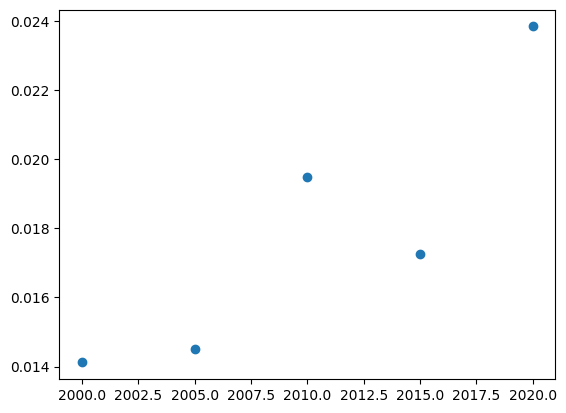

In [13]:
plt.scatter(x=YEARS, y=known_values)

In [14]:
x = np.array(YEARS)
y = np.array(known_values)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [15]:
x, y

(array([[2000],
        [2005],
        [2010],
        [2015],
        [2020]]),
 array([[0.01411801],
        [0.01449343],
        [0.0194928 ],
        [0.01726543],
        [0.02383335]], dtype=float32))

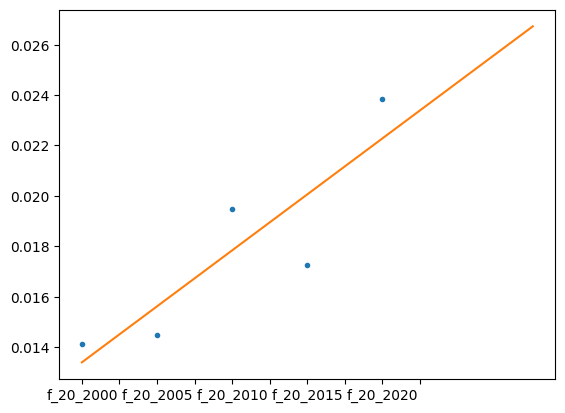

In [16]:
regr = linear_model.LinearRegression().fit(x, y)

time_extent = np.array([2000, 2005, 2010, 2015, 2020, 2025, 2030]).reshape(-1, 1)

fig, ax = plt.subplots()

row[2:].plot(ax=ax, style=".")
ax.plot(regr.predict(time_extent))

In [17]:
future = np.array(PREDICTION_YEARS).reshape(-1, 1)

prediction_values = regr.predict(future)
prediction_values

array([[0.02272519],
       [0.02316924],
       [0.0236133 ],
       [0.02405735],
       [0.0245014 ],
       [0.02494546],
       [0.02538951],
       [0.02583357],
       [0.02627762],
       [0.02672167]])

<Axes: >

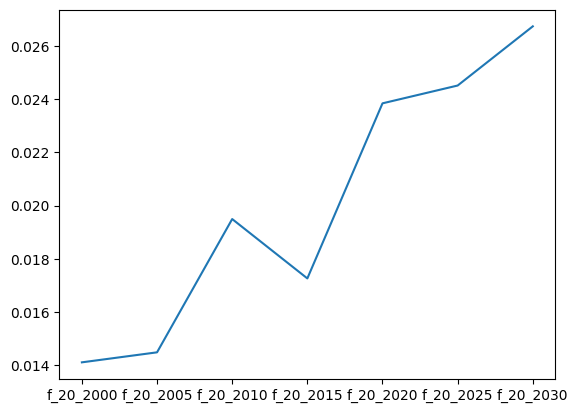

In [18]:
prediction_columns = [f"{pop_group}_{year}" for year in PREDICTION_YEARS]
example_row = row.reindex([*df.columns, *prediction_columns])
prediction_values = prediction_values.flatten()
example_row[prediction_columns] = pd.Series(list(prediction_values))

example_row[[
    'f_20_2000',
    'f_20_2005',
    'f_20_2010',
    'f_20_2015',
    'f_20_2020',
    'f_20_2025',
    'f_20_2030',
]].plot()

In [19]:
from scripts.data_analysis.predict_population import predict_population

In [20]:
def predict_population(row, known_years, prediction_years, pop_group, model):
    known_values = row.values

    x = np.array(known_years)
    y = np.array(known_values)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    regr = model.fit(x, y)

    prediction_years_array = np.array(prediction_years).reshape(-1, 1)
    prediction_values = regr.predict(prediction_years_array)

    return prediction_values.flatten()

In [21]:
cols = ['f_20_2000', 'f_20_2005', 'f_20_2010', 'f_20_2015', 'f_20_2020']

In [22]:
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [23]:
model = linear_model.LinearRegression()

predicted = filtered[cols].parallel_apply(lambda row: predict_population(
    row, YEARS, PREDICTION_YEARS, pop_group, model
), axis="columns", result_type="expand")

In [24]:
predicted.columns = prediction_columns

In [25]:
predicted.head()

,f_20_2021,f_20_2022,f_20_2023,f_20_2024,f_20_2025,f_20_2026,f_20_2027,f_20_2028,f_20_2029,f_20_2030
460,0.015568,0.015713,0.015858,0.016003,0.016148,0.016293,0.016438,0.016583,0.016728,0.016873
461,0.015464,0.015591,0.015719,0.015847,0.015974,0.016102,0.016230,0.016358,0.016485,0.016613
462,0.015614,0.015737,0.015860,0.015983,0.016106,0.016229,0.016352,0.016475,0.016598,0.016721
463,0.015497,0.015617,0.015738,0.015858,0.015979,0.016100,0.016220,0.016341,0.016461,0.016582
464,0.015488,0.015595,0.015702,0.015809,0.015916,0.016023,0.016130,0.016237,0.016344,0.016451


In [26]:
predicted_with_coords = pd.concat([predicted, filtered[["x", "y"]]], axis=1)
geo = gpd.GeoDataFrame(
    predicted_with_coords,
    geometry=gpd.points_from_xy(predicted_with_coords["x"], predicted_with_coords["y"]),
    crs="epsg:4326"
)

In [27]:
geo.head()

,f_20_2021,f_20_2022,f_20_2023,f_20_2024,f_20_2025,f_20_2026,f_20_2027,f_20_2028,f_20_2029,f_20_2030,x,y,geometry
460,0.015568,0.015713,0.015858,0.016003,0.016148,0.016293,0.016438,0.016583,0.016728,0.016873,1.219167,10.041667,POINT (1.21917 10.04167)
461,0.015464,0.015591,0.015719,0.015847,0.015974,0.016102,0.016230,0.016358,0.016485,0.016613,1.220000,10.041667,POINT (1.22000 10.04167)
462,0.015614,0.015737,0.015860,0.015983,0.016106,0.016229,0.016352,0.016475,0.016598,0.016721,1.220833,10.041667,POINT (1.22083 10.04167)
463,0.015497,0.015617,0.015738,0.015858,0.015979,0.016100,0.016220,0.016341,0.016461,0.016582,1.221667,10.041667,POINT (1.22167 10.04167)
464,0.015488,0.015595,0.015702,0.015809,0.015916,0.016023,0.016130,0.016237,0.016344,0.016451,1.222500,10.041667,POINT (1.22250 10.04167)


In [28]:
resolution = np.float32(meta["transform"][4]), np.float32(meta["transform"][0])
resolution

(-0.00083333335, 0.00083333335)

In [29]:
from geocube.api.core import make_geocube

out_grid = make_geocube(
    vector_data=geo,
    measurements=["f_20_2030"],
    resolution=resolution
)
out_grid["f_20_2030"].rio.to_raster("sklearn_predict_2030.tif")